# Simple Example of using WebLoader with PyTorch

In a separate window, start the server with:

```
        curl http://storage.googleapis.com/lpr-imagenet-augmented/imagenet_train-0000-000.tgz > training.tgz
        serve-imagenet -u training.tgz -b 64
```

Or, if you have a local clone of the entire dataset:

```
        serve-imagenet -u http://my-server/some-path/imagenet_train-{0000..0147}-{000..019}.tgz
```

In [1]:
%matplotlib inline

In [2]:
from importlib import reload

import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
from torchvision import models

import webloader as wl
import tensorcom as tc

from IPython import display
import matplotlib.pyplot as plt


In [3]:
mean = np.array([0.485, 0.456, 0.406], "f")
std = np.array([0.229, 0.224, 0.225], "f")
def norm_image(xs):
    return (xs-mean[None,None,None,:])/std[None,None,None,:]
def norm_cls(ys):
    ys = ys.astype(np.int64)
    return ys-1

In [4]:
#urls = "http://storage.googleapis.com/lpr-imagenet-augmented/imagenet_train-{0000..0147}-{000..019}.tgz"
num_samples = 1000000
training = tc.Connection("zsub://127.0.0.1:7880",
                         epoch=num_samples,
                         batch_transforms=[norm_image, norm_cls],
                         converters="torch")
xs, ys = next(iter(training))
print(xs.shape, xs.dtype, xs.min().item(), xs.max().item())
print(ys.shape, ys.dtype, ys.min().item(), ys.max().item())

torch.Size([64, 3, 224, 224]) torch.float32 -2.1179039478302 1136.357177734375
torch.Size([64]) torch.int64 39 980


In [5]:
model = models.resnet50()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), 0.0001, momentum=0.9, weight_decay=0.0)

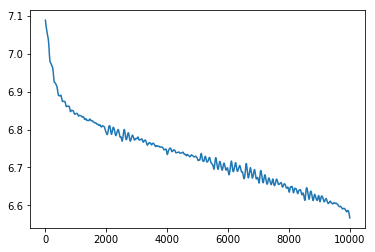

In [6]:
def rtplot(ys, xs=None, sigma=20, fig=None):
    fig = fig or plt.gcf()
    fig.clf()
    fig.add_subplot(1, 1, 1)
    ax = fig.get_axes()[0]
    ax.cla()
    from scipy.ndimage import filters
    ys = filters.gaussian_filter(np.array(ys, "f"), sigma, mode="nearest")
    if xs is not None:
        plt.plot(xs, ys)
    else:
        plt.plot(ys)
    display.clear_output(wait=True)
    display.display(fig)
        
def train_for(steps, losses=[]):
    model.cuda()
    model.train()
    for i, (input, target) in enumerate(training):
        if i>=steps: break
        output = model(input.cuda())
        loss = criterion(output, target.cuda())
        losses.append(loss.item())
        rtplot(losses)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    display.clear_output(wait=True)
        
train_for(10000)